<a href="https://colab.research.google.com/github/dtabuena/Workshop/blob/main/Ripples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
'Get Standard Modules'

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import os
from scipy.signal import butter,filtfilt
from tqdm import tqdm
import warnings
from IPython.display import clear_output
from datetime import datetime
import sys
import warnings
import shutil
from google.colab import files


warnings.filterwarnings('ignore')
np.set_printoptions(threshold=sys.maxsize)
clear_output(wait=False)



!pip install openpyxl
!pip install XlsxWriter
!pip install --upgrade pyabf
import pyabf

'''Get Repositories'''
try: shutil.rmtree('/content/EphysLib')
except: None




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 kB 2.9 MB/s eta 0:00:00


In [2]:
def get_drobox_folder(link, new_filename):
    'Download a folder from dropbox and unzip'
    zipped_file_path = "/content/"+new_filename + ".zip"
    unzipped_file_path = "/content/"+new_filename
    if not( os.path.exists(zipped_file_path)):
        !wget -O $zipped_file_path $link    # download with new name
    # if not( os.path.exists(new_filename_stripped)):
    !echo A | unzip $zipped_file_path -d $unzipped_file_path
    return new_filename

In [3]:
def z_trans_2(x):
    x_mean = np.expand_dims(np.mean(x,axis=1),1)
    x_std = np.expand_dims(np.std(x,axis=1),1)
    x_z = (x - x_mean) / x_std
    return x_z

def z_trans(x):
    x_mean = np.mean(x)
    x_std = np.std(x)
    x_z = (x - x_mean) / x_std
    return x_z

def mov_mean(x,stride):
    x_mm = np.convolve(x,np.ones(stride),'same')/stride
    return x_mm

In [4]:
data_source = "https://www.dropbox.com/sh/03361h631eiyi03/AAANIvLRFaTcsbMoD_FsUS7_a?dl=0"
data_name = 'Bumet'

file_loc = get_drobox_folder(data_source, data_name +'_ephys_data')

--2023-07-12 18:08:35--  https://www.dropbox.com/sh/03361h631eiyi03/AAANIvLRFaTcsbMoD_FsUS7_a?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /sh/raw/03361h631eiyi03/AAANIvLRFaTcsbMoD_FsUS7_a [following]
--2023-07-12 18:08:35--  https://www.dropbox.com/sh/raw/03361h631eiyi03/AAANIvLRFaTcsbMoD_FsUS7_a
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf604d8d3f07133cd2c2e5cdab9.dl.dropboxusercontent.com/zip_download_get/BjISQOyWrjA0coXoXaGPYBMbTudgQlsIsccew5Mb5CIQwtDcVadhblYPQkJNz4UlStjbnAPaY15nNup5vaLmJBkgK1inbTfx_3auw1aRco3wRw# [following]
--2023-07-12 18:08:36--  https://ucf604d8d3f07133cd2c2e5cdab9.dl.dropboxusercontent.com/zip_download_get/BjISQOyWrjA0coXoXaGPYBMbTudgQlsIsccew5Mb5CIQwtDcVadhblYPQkJNz4UlStjbnAPaY15nNup5vaLmJBkgK

5000


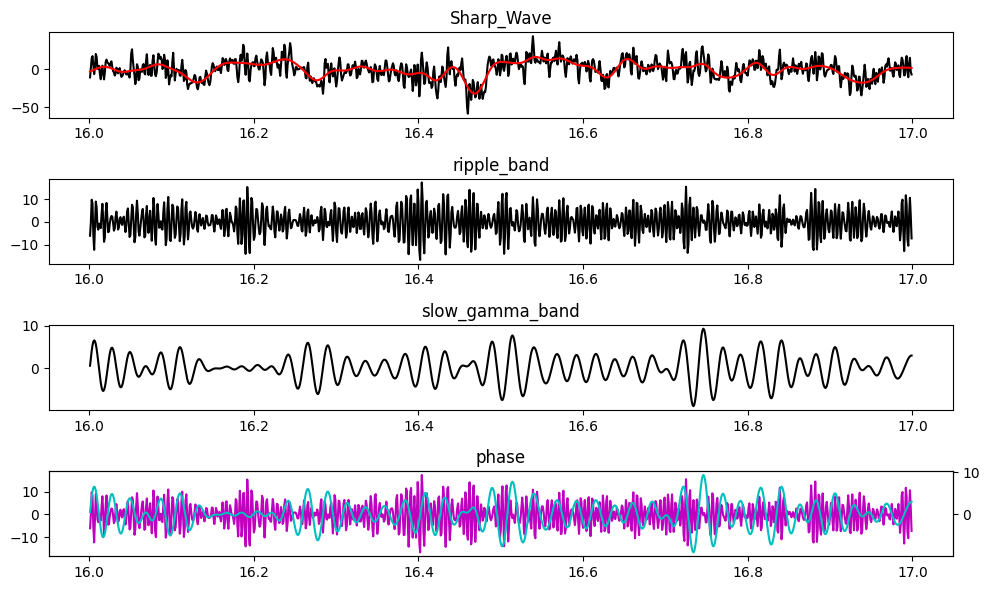

In [5]:
#### Gillespie et al Method
abf = pyabf.ABF('/content/Bumet_ephys_data/2023x07x06_E3KI_F_P525_s3x4_0000.abf')



fs = abf.sampleRate
print(fs)
abf.setSweep(sweepNumber=0,channel=0)
v_trace = abf.sweepY
time = abf.sweepX

ds_factor = np.ceil(fs/1000)
v_trace_1khz = v_trace[::int(ds_factor)]
time_1khz = time[::int(ds_factor)]
fs = 1000

order = 4

b, a = scipy.signal.butter(order, [0.7,300], btype='bandpass',fs=fs)
narrow_band = scipy.signal.filtfilt(b, a, v_trace_1khz)

b, a = scipy.signal.butter(order, [150,250], btype='bandpass',fs=fs)
ripple_band = scipy.signal.filtfilt(b, a, v_trace_1khz)

b, a = scipy.signal.butter(order, [30 ,50], btype='bandpass',fs=fs)
slow_gamma_band = scipy.signal.filtfilt(b, a, v_trace_1khz)

b, a = scipy.signal.butter(order, [1 ,30], btype='bandpass',fs=fs)
sharp_wave_band = scipy.signal.filtfilt(b, a, v_trace_1khz)

b, a = scipy.signal.butter(order, [6 ,12], btype='bandpass',fs=fs)
theta_band = scipy.signal.filtfilt(b, a, v_trace_1khz)

#### Set plot
plot_window = [16,17]
t_condit = np.logical_and(time_1khz>plot_window[0] , time_1khz<plot_window[1])
fig,ax = plt.subplots(4,1,figsize=(10,6))
ax=ax.flatten()
ax[0].plot(time_1khz[t_condit],narrow_band[t_condit] * 1000,'k')
ax[0].plot(time_1khz[t_condit],sharp_wave_band[t_condit] * 1000,'r')
ax[0].set_title('Sharp_Wave')

ax[1].plot(time_1khz[t_condit],ripple_band[t_condit] * 1000,'k')
ax[1].set_title('ripple_band')

ax[2].plot(time_1khz[t_condit],slow_gamma_band[t_condit] * 1000,'k')
ax[2].set_title('slow_gamma_band')


ax[3].plot(time_1khz[t_condit],ripple_band[t_condit] * 1000,'m')
ax[3].twinx().plot(time_1khz[t_condit],slow_gamma_band[t_condit] * 1000,'c')
ax[3].set_title('phase')

plt.tight_layout()

In [84]:
def time_bands(abf,sweepNumber=0,channel=0):
    fs = abf.sampleRate
    abf.setSweep(sweepNumber=sweepNumber,channel=channel)
    v_trace = abf.sweepY
    time = abf.sweepX

    new_fs = 1000
    ds_factor = np.ceil(fs/new_fs)
    v_trace_1khz = v_trace[::int(ds_factor)]
    time_1khz = time[::int(ds_factor)]


    order = 4

    b, a = scipy.signal.butter(order, [0.7,300], btype='bandpass',fs=new_fs)
    narrow_band = scipy.signal.filtfilt(b, a, v_trace_1khz)

    b, a = scipy.signal.butter(order, [150,250], btype='bandpass',fs=new_fs)
    ripple_band = scipy.signal.filtfilt(b, a, v_trace_1khz)

    b, a = scipy.signal.butter(order, [30 ,50], btype='bandpass',fs=new_fs)
    slow_gamma_band = scipy.signal.filtfilt(b, a, v_trace_1khz)

    b, a = scipy.signal.butter(order, [1 ,30], btype='bandpass',fs=new_fs)
    sharp_wave_band = scipy.signal.filtfilt(b, a, v_trace_1khz)

    b, a = scipy.signal.butter(order, [6 ,12], btype='bandpass',fs=new_fs)
    theta_band = scipy.signal.filtfilt(b, a, v_trace_1khz)

    return fs, narrow_band, sharp_wave_band, ripple_band, slow_gamma_band, theta_band

fs, narrow_band, sharp_wave_band, ripple_band,_,_= time_bands(abf,sweepNumber=0,channel=0)


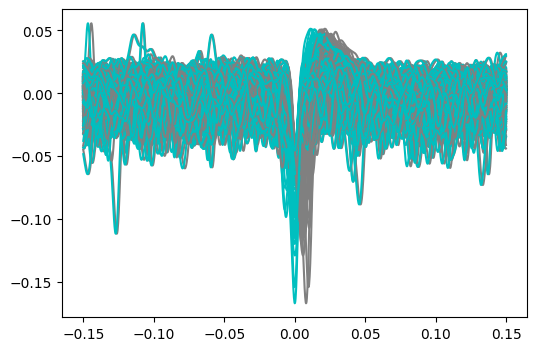

In [88]:
def get_SW_trig_inds(sharp_wave_band,fs,sw_thresh=-4):
    '''find the crossings from the sharwave and return trigger indexes'''
    trig_bool = z_trans(sharp_wave_band)<-4
    mov_wind=15
    trig_bool = z_trans(sharp_wave_band)<-4
    trigs = np.where(np.diff(trig_bool,prepend=0)*1>.5)[0]
    peak_window_s = np.array([-25,25])/1000
    peak_window_tic = np.arange(peak_window_s[0]*fs,peak_window_s[1]*fs,1,dtype=int)
    plot_window_s = np.array([-150,150])/1000
    plot_window_tic = np.arange(plot_window_s[0]*fs,plot_window_s[1]*fs,1,dtype=int)
    fig,ax=plt.subplots(1,1, figsize=(6,4))

    trigs_alligned = []
    for t in trigs:
        sharp_wave_snip = sharp_wave_band[t+peak_window_tic]
        local_min_tic = np.where(sharp_wave_snip==np.min(sharp_wave_snip))[0][0]
        adjusted_t = t + local_min_tic+peak_window_tic[0]
        if t< 100000000000000:
            ax.plot(plot_window_tic/fs,sharp_wave_band[t+plot_window_tic],'grey')
            ax.plot(plot_window_tic/fs,sharp_wave_band[adjusted_t+plot_window_tic],'c')
        trigs_alligned.append(adjusted_t)

    return trigs_alligned
trigs =  get_SW_trig_inds(sharp_wave_band,fs,sw_thresh=-4)

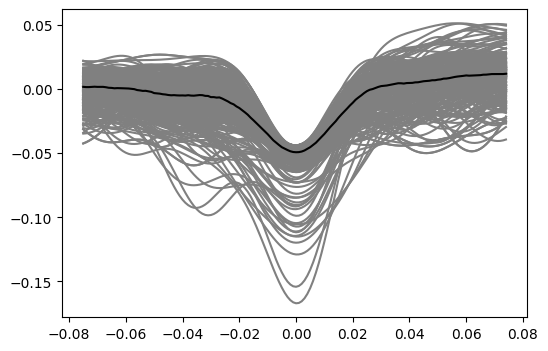

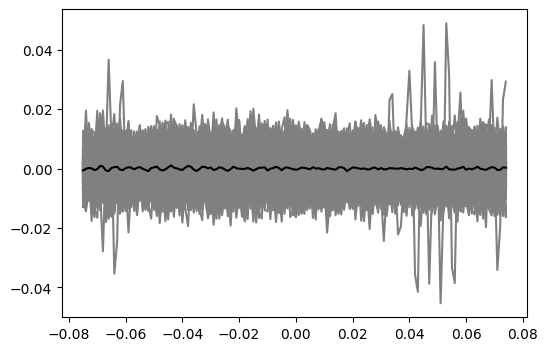

In [99]:
def get_waveforms_stack(waveform,trigs,fs,window_ms=[-150,150]):
    window_s = np.array(window_ms)/fs
    window_tics = np.arange(plot_window_s[0]*fs,plot_window_s[1]*fs,1,dtype=int)
    fig,ax=plt.subplots(1,1, figsize=(6,4))
    wave_snip_list= [waveform[t+window_tics] for t in trigs]
    wave_snip_stack = np.stack(wave_snip_list,axis=-1)
    ax.plot(window_tics/fs,wave_snip_stack,'grey')
    ax.plot(window_tics/fs,np.median(wave_snip_stack,axis=1),'k')
    return wave_snip_stack
sharp_wave_stack = get_waveforms_stack(sharp_wave_band,trigs,fs=1000,window_ms=[-150,150])
ripple_stack = get_waveforms_stack(ripple_band,trigs,fs=1000,window_ms=[-150,150])

[29596, 30375, 39016, 49224, 52790, 64312, 68906, 70409, 80018, 148467, 169835, 182329, 192435, 244882, 244919, 278124, 278522, 291626, 317239, 317675, 319620, 331411, 356521, 356749, 358083, 358392, 369603, 387855, 402695, 407885, 410786, 420322, 421165, 429782, 439880, 440288, 443972, 449563, 450576, 452491, 454767, 462220, 474500, 481083, 492136, 494350, 496276, 498195, 508997, 520802, 524671, 531221, 545688, 558985, 562233, 564258, 576018, 590209, 592843, 600315, 600735, 604498, 607817, 610228, 612281, 633312, 642951, 655115, 665664, 670830, 671316, 679454, 683233, 690759, 713077, 713633, 725041, 896613, 969288, 1049342, 1049549, 1057417, 1064919, 1069860, 1073104, 1075244, 1077077, 1079215, 1085387, 1090664, 1092128, 1093305, 1095134, 1098357, 1101338, 1103655, 1111505, 1113323, 1118005, 1122329, 1123235, 1130383, 1131419, 1132065, 1132668, 1139100, 1143702, 1143925, 1150304, 1150989, 1153210, 1157737, 1162303, 1162497, 1166715, 1178758, 1181048, 1186660, 1191503, 1192815, 1199166

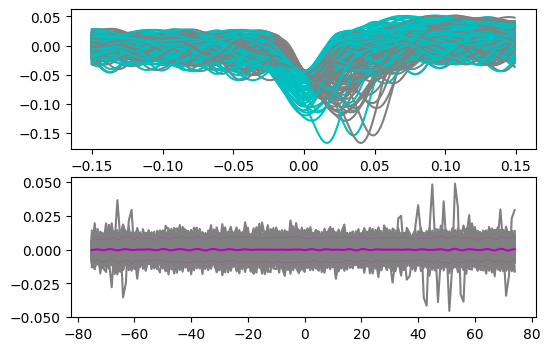

In [12]:
### Trigger on Sharp_Wave

mov_wind=15
trig_bool = z_trans(sharp_wave_band)<-4
trigs = np.where(np.diff(trig_bool,prepend=0)*1>.5)[0]
peak_window_s = np.array([-25,25])/1000
peak_window_tic = np.arange(peak_window_s[0]*fs,peak_window_s[1]*fs,1,dtype=int)
plot_window_s = np.array([-150,150])/1000
plot_window_tic = np.arange(plot_window_s[0]*fs,plot_window_s[1]*fs,1,dtype=int)
fig,ax=plt.subplots(2,1, figsize=(6,4))
# ax0r = ax[0].twinx()

trigs_alligned = []
for t in trigs:
    sharp_wave_snip = sharp_wave_band[t+peak_window_tic]
    local_min_tic = np.where(sharp_wave_snip==np.min(sharp_wave_snip))[0][0]
    adjusted_t = t + local_min_tic+peak_window_tic[0]
    if t< 100000000000000:
        ax[0].plot(plot_window_tic/fs,sharp_wave_band[t+plot_window_tic],'grey')
        ax[0].plot(plot_window_tic/fs,sharp_wave_band[adjusted_t+plot_window_tic],'c')
    trigs_alligned.append(adjusted_t)
print(trigs_alligned)



rip_list = []

plot_window_s = np.array([-75,75])/1000
plot_window_tic = np.arange(plot_window_s[0]*fs,plot_window_s[1]*fs,1,dtype=int)


# fig,ax=plt.subplots()
for t in trigs_alligned:
    rip_wave_snip = ripple_band[t+plot_window_tic]
    rip_list.append(rip_wave_snip)
    # if t< 1000000000000:
    ax[1].plot(plot_window_tic/fs*1000,rip_wave_snip,'grey')

rip_list = np.stack(rip_list)
rip_list.shape
rip_mean = np.mean(rip_list,axis=0)
rip_std = np.std(rip_list,axis=0)
rip_percentile_hi = np.percentile(rip_list,95,axis=0)
rip_percentile_lo = np.percentile(rip_list,5,axis=0)
ax[1].plot(plot_window_tic/fs*1000,rip_mean,'m')
ax[1].plot(plot_window_tic/fs*1000,rip_percentile_hi,'m',linewidth=.1)
ax[1].plot(plot_window_tic/fs*1000,rip_percentile_lo,'m',linewidth=.1)

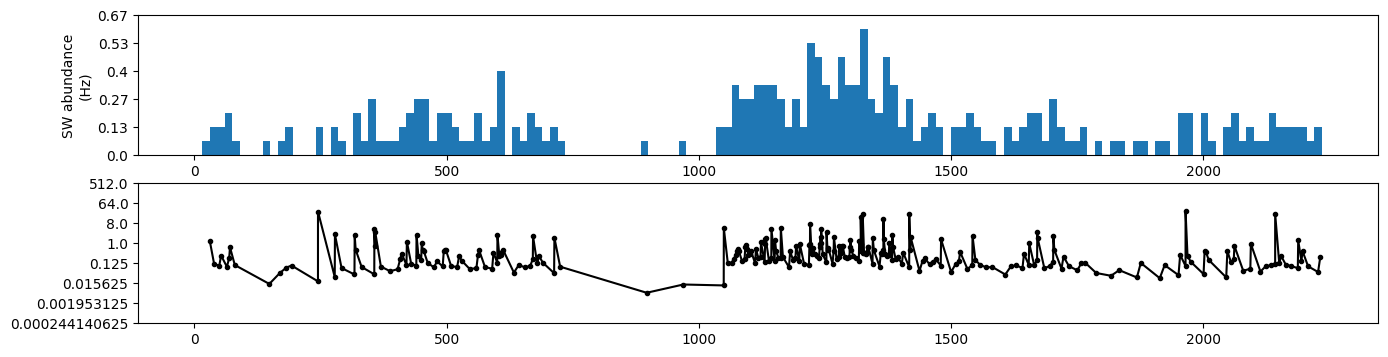

In [81]:
sharp_wave_instrate = fs/np.diff(trigs_alligned)
fig,ax=plt.subplots(2,1,figsize=(16,4))

bin_wid = 15
ax[0].hist(time_1khz[trigs_alligned],bins=np.arange(0,np.max(time_1khz)+bin_wid,bin_wid))
ax[0].set_ylabel('SW abundance'+'\n'+'(Hz)')
ax[0].set_yticks(ax[0].get_yticks(),['{:,.2}'.format(y/bin_wid) for y in ax[0].get_yticks()])

ax[1].plot(time_1khz[trigs_alligned[1:]],sharp_wave_instrate,'.-k')
ax[1].set_yscale('log', base=2)
ylims_auto =ax[1].get_ylim()
yticks_auto = ax[1].get_yticks()
yticks_auto_str = [str(tic) for tic in yticks_auto]
ax[1].set_yticks(yticks_auto,yticks_auto_str)

for a in ax:
    a.set_xlim(ax[0].get_xlim())
plt.show()


In [ ]:

#### Set plot
plot_window = [10,15]
t_condit = np.logical_and(time_1khz>plot_window[0] , time_1khz<plot_window[1])


w = 6.
top_freq = fs/2
top_freq = 600
freq = np.logspace(np.log2(10), np.log2(top_freq), num=80, endpoint=True, base=2)
widths = w*fs / (2*freq*np.pi)
cwtm = scipy.signal.cwt(narrow_band, scipy.signal.morlet2, widths, w=w)

cw_abs = np.abs(cwtm)
cw_mean = np.expand_dims(np.mean(cw_abs,axis=1),-1)
cw_std = np.expand_dims(np.std(cw_abs,axis=1),-1)
cw_z = (cw_abs - cw_mean) / cw_std

fig,ax=plt.subplots(2,2, figsize=(16,4),gridspec_kw={"height_ratios":[1,1],"width_ratios":[99,1]})
ax=ax.flatten()
cb= ax[0].pcolormesh(time_1khz[t_condit],freq,cw_z[:,t_condit],cmap='hot')
fig.colorbar(cb,cax=ax[1])
ax[2].plot(time_1khz[t_condit],narrow_band[t_condit] * 1000,'k')
ax[3].axis('off')
plt.tight_layout()
xlims = ax[0].get_xlim()
for a in ax: a.set_xlim(xlims)
ax[0].set_yscale('log')

In [ ]:
# from scipy import signal





fs = 10000
w = 6.
top_freq = fs/2
top_freq = 600
freq = np.linspace(1, top_freq, 100)
freq = np.logspace(np.log2(10), np.log2(top_freq), num=40, endpoint=True, base=2)
widths = w*fs / (2*freq*np.pi)
cwtm = scipy.signal.cwt(in0, scipy.signal.morlet2, widths, w=w)

cw_abs = np.abs(cwtm)
cw_mean = np.expand_dims(np.mean(cw_abs,axis=1),-1)
cw_std = np.expand_dims(np.std(cw_abs,axis=1),-1)
cw_z = (cw_abs - cw_mean) / cw_std





In [ ]:
b, a = scipy.signal.butter(2, [4,120], btype='bandpass',fs=10000)
gamma_band = scipy.signal.filtfilt(b, a, in0)
gamma_band_z = z_trans(gamma_band)
trig = np.diff(gamma_band_z<-3,prepend=0)==1

b, a = scipy.signal.butter(4, [130,180], btype='bandpass',fs=10000)
ripple_band = scipy.signal.filtfilt(b, a, in0-gamma_band)
ripple_band_z= z_trans(ripple_band)

trig_ind = np.where(trig)[0]

wave_list = []
trig_ind_peaks = []
for t in trig_ind:
    try:
        prepend_g = 1500
        append_g = 1500
        sub_x = np.arange(t-prepend_g,t+append_g)
        sub_y = gamma_band[sub_x]
        min_ind = np.where(sub_y==np.min(sub_y))[0][0]
        t_adj=t+(min_ind-prepend_g)
        sub_x = np.arange(t_adj-prepend_g,t_adj+append_g)
        sub_y = gamma_band[sub_x]
        wave_list.append(sub_y)
        trig_ind_peaks.append(t_adj)
    except: None

rip_list = []
for t in trig_ind_peaks:
    try:
        prepend_r = 500
        append_r = 500
        t=t
        sub_x = np.arange(t-prepend_r,t+append_r)
        sub_y = ripple_band[sub_x]
        rip_list.append(sub_y)
    except: None

window_t_g = np.arange(-prepend_g,append_g)/10000*1000
window_t_r = np.arange(-prepend_r,append_r)/10000*1000

rips = np.stack(rip_list)
waves = np.stack(wave_list)
fig,ax=plt.subplots(1,4,figsize=[12,4],gridspec_kw={'width_ratios':[30,30,30,1]})
ax=ax.flatten()
ax[0].plot(window_t_g, waves.T*1000,color='grey',zorder=-1)
ax[0].plot(window_t_g, np.mean(waves,axis=0)*1000,'r',zorder=999)
ax[1].plot(window_t_r,rips.T*1000,color='grey')
ax[1].plot(window_t_r,np.mean(rips,axis=0)*1000,'r',zorder=999)



cw_list = []
prepend_g = 1500
append_g = 1500
for t in trig_ind_peaks:
    try:
        sub_x = np.arange(t-prepend_g,t+append_g)
        cw_list.append(cw_z[:,sub_x])
    except: None

cw_stack = np.stack(cw_list,axis=-1)
cw_mean = np.mean(cw_stack,-1)
cb= ax[2].pcolormesh(window_t_g,freq,cw_mean,cmap='hot')
fig.colorbar(cb,cax=ax[3])
num_SWs = len(trig_ind_peaks)
rate = round(num_SWs/len(in0)*10000,2)

ax[0].set_title('Sharp_Waves (n=' + str(num_SWs)+'; '+str(rate)+'/s)')
ax[0].set_ylabel('LFP (uV)')
ax[1].set_title('SW triggered Ripple_Band')
ax[1].set_ylabel('LFP (uV)')
ax[2].set_title('SW triggered WaveletSpectrogram')
ax[2].set_ylabel('Freq (Hz)')
ax[3].set_ylabel('z_power')
for a in ax[:-1]:
    a.set_xlabel('time (ms)')

plt.tight_layout()